In [21]:
import matplotlib 
from matplotlib import pyplot as plt

In [8]:
# Load MNIST data

import numpy as np
import gzip
import struct


def load_images(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Read the header information into a bunch of variables:
        _ignored, n_images, columns, rows = struct.unpack('>IIII', f.read(16))
        # Read all the pixels into a NumPy array of bytes:
        all_pixels = np.frombuffer(f.read(), dtype=np.uint8)
        # Reshape the pixels into a matrix where each line is an image:
        return all_pixels.reshape(n_images, columns * rows)


# 60000 images, each 784 elements (28 * 28 pixels)
X_train = load_images("../data/mnist/train-images-idx3-ubyte.gz")

# 10000 images, each 784 elements, with the same structure as X_train
X_test = load_images("../data/mnist/t10k-images-idx3-ubyte.gz")


def load_labels(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Skip the header bytes:
        f.read(8)
        # Read all the labels into a list:
        all_labels = f.read()
        # Reshape the list of labels into a one-column matrix:
        return np.frombuffer(all_labels, dtype=np.uint8).reshape(-1, 1)


def one_hot_encode(Y):
    n_labels = Y.shape[0]
    n_classes = 10
    encoded_Y = np.zeros((n_labels, n_classes))
    for i in range(n_labels):
        label = Y[i]
        encoded_Y[i][label] = 1
    return encoded_Y


# !!! EDIT PATHS TO WHERE YOUR MNIST DATA IS !!!

# 60K labels, each a single digit from 0 to 9
Y_train_unencoded = load_labels("../data/mnist/train-labels-idx1-ubyte.gz")

# 60K labels, each consisting of 10 one-hot encoded elements
Y_train = one_hot_encode(Y_train_unencoded)

# 10000 labels, each a single digit from 0 to 9
Y_test = load_labels("../data/mnist/t10k-labels-idx1-ubyte.gz")

In [18]:
# A neural network implementation (almost the same as backpropagation.py,
# except for a tiny refactoring in the back() function).

import numpy as np


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def softmax(logits):
    exponentials = np.exp(logits)
    return exponentials / np.sum(exponentials, axis=1).reshape(-1, 1)


def sigmoid_gradient(sigmoid):
    return np.multiply(sigmoid, (1 - sigmoid))


def loss(Y, y_hat):
    return -np.sum(Y * np.log(y_hat)) / Y.shape[0]


def prepend_bias(X):
    return np.insert(X, 0, 1, axis=1)


def forward(X, w1, w2):
    h = sigmoid(np.matmul(prepend_bias(X), w1))
    y_hat = softmax(np.matmul(prepend_bias(h), w2))
    return (y_hat, h)


def back(X, Y, y_hat, w2, h):
    w2_gradient = np.matmul(prepend_bias(h).T, (y_hat - Y)) / X.shape[0]
    w1_gradient = np.matmul(prepend_bias(X).T, np.matmul(y_hat - Y, w2[1:].T)
                            * sigmoid_gradient(h)) / X.shape[0]
    return (w1_gradient, w2_gradient)


def classify(X, w1, w2):
    y_hat, _ = forward(X, w1, w2)
    labels = np.argmax(y_hat, axis=1)
    return labels.reshape(-1, 1)


def initialize_weights(n_input_variables, n_hidden_nodes, n_classes):
    w1_rows = n_input_variables + 1
    w1 = np.random.randn(w1_rows, n_hidden_nodes) * np.sqrt(1 / w1_rows)

    w2_rows = n_hidden_nodes + 1
    w2 = np.random.randn(w2_rows, n_classes) * np.sqrt(1 / w2_rows)

    return (w1, w2)


def report(iteration, X_train, Y_train, X_test, Y_test, w1, w2):
    y_hat, _ = forward(X_train, w1, w2)
    training_loss = loss(Y_train, y_hat)
    classifications = classify(X_test, w1, w2)
    accuracy = np.average(classifications == Y_test) * 100.0
    print("Iteration: %5d, Loss: %.8f, Accuracy: %.2f%%" %
          (iteration, training_loss, accuracy))
    return accuracy

def report_JR(iteration, X_train, Y_train, X_test, Y_test, w):
    matches = np.count_nonzero(classify(X_test, w) == Y_test)
    n_test_ex = Y_test.shape[0]
    matches = matches * 100.0 / n_test_ex
    training_loss = loss(X_train, Y_train, w)
    print('iteration {} - loss: {:.2f}, matches: {:.2f}%'.format(iteration, training_loss, matches))
    return matches

    

def train(X_train, Y_train, X_test, Y_test, n_hidden_nodes, iterations, lr):
    success_rates = []
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]
    w1, w2 = initialize_weights(n_input_variables, n_hidden_nodes, n_classes)
    for iteration in range(iterations):
        y_hat, h = forward(X_train, w1, w2)
        w1_gradient, w2_gradient = back(X_train, Y_train, y_hat, w2, h)
        w1 = w1 - (w1_gradient * lr)
        w2 = w2 - (w2_gradient * lr)
        accuracy = report(iteration, X_train, Y_train, X_test, Y_test, w1, w2)
        success_rates.append(accuracy)
    return (w1, w2, success_rates)


In [113]:
# create a dictionary to store your success rates
# !!! UNCOMMENT, EXECUTE, AND COMMENT THE LINE BELOW AGAIN !!!
# !!! DON'T EXECUTE THE LINE AGAIN AFTER STARTING TO COLLECT RESULTS !!!

#success_rates = {}

In [112]:
n_train = 6000 # number of examples in training data (max is 60,000)
n_test  = 1000 # number of examples in training data (max is 10,000)
n_nodes = 3000 # number of hidden nodes
n_iters = 1000 # number of iterations
lr      = 0.03

# create a string with the parameter values
lr_str = str(lr).replace('.', 'p')
name = 'success_rates_train{}_test{}_nodes{}_iters{}_lr'.format(n_train, n_test, n_nodes, n_iters)+lr_str


(w1, w2, sr) = train(X_train[:n_train], Y_train[:n_train], 
               X_test[:n_test], Y_test[:n_test], 
               n_hidden_nodes=n_nodes, iterations=n_iters, lr=lr)
# store the corrent success rates in the dictionary named success rates
success_rates[name] = sr

Iteration:     0, Loss: 2.37164695, Accuracy: 15.70%
Iteration:     1, Loss: 2.29462793, Accuracy: 32.30%
Iteration:     2, Loss: 2.03039867, Accuracy: 22.90%
Iteration:     3, Loss: 2.04196651, Accuracy: 50.70%
Iteration:     4, Loss: 1.46653734, Accuracy: 47.30%
Iteration:     5, Loss: 1.57082043, Accuracy: 55.50%
Iteration:     6, Loss: 1.34825780, Accuracy: 46.80%
Iteration:     7, Loss: 1.42520856, Accuracy: 53.10%
Iteration:     8, Loss: 1.33148927, Accuracy: 51.80%
Iteration:     9, Loss: 1.27331302, Accuracy: 63.20%
Iteration:    10, Loss: 1.07850681, Accuracy: 58.80%
Iteration:    11, Loss: 1.04265363, Accuracy: 63.20%
Iteration:    12, Loss: 0.99841548, Accuracy: 59.00%
Iteration:    13, Loss: 1.06728162, Accuracy: 66.20%
Iteration:    14, Loss: 0.82660532, Accuracy: 70.70%
Iteration:    15, Loss: 0.80988150, Accuracy: 69.50%
Iteration:    16, Loss: 0.77379814, Accuracy: 69.70%
Iteration:    17, Loss: 0.82533940, Accuracy: 70.00%
Iteration:    18, Loss: 0.71785554, Accuracy: 

Iteration:   155, Loss: 0.17797299, Accuracy: 87.40%
Iteration:   156, Loss: 0.17722136, Accuracy: 87.30%
Iteration:   157, Loss: 0.17647664, Accuracy: 87.30%
Iteration:   158, Loss: 0.17573874, Accuracy: 87.30%
Iteration:   159, Loss: 0.17500761, Accuracy: 87.30%
Iteration:   160, Loss: 0.17428312, Accuracy: 87.30%
Iteration:   161, Loss: 0.17356512, Accuracy: 87.40%
Iteration:   162, Loss: 0.17285351, Accuracy: 87.40%
Iteration:   163, Loss: 0.17214824, Accuracy: 87.40%
Iteration:   164, Loss: 0.17144929, Accuracy: 87.40%
Iteration:   165, Loss: 0.17075658, Accuracy: 87.40%
Iteration:   166, Loss: 0.17006998, Accuracy: 87.40%
Iteration:   167, Loss: 0.16938939, Accuracy: 87.50%
Iteration:   168, Loss: 0.16871468, Accuracy: 87.50%
Iteration:   169, Loss: 0.16804578, Accuracy: 87.50%
Iteration:   170, Loss: 0.16738256, Accuracy: 87.50%
Iteration:   171, Loss: 0.16672490, Accuracy: 87.50%
Iteration:   172, Loss: 0.16607266, Accuracy: 87.50%
Iteration:   173, Loss: 0.16542571, Accuracy: 

Iteration:   310, Loss: 0.10857767, Accuracy: 88.90%
Iteration:   311, Loss: 0.10830381, Accuracy: 88.90%
Iteration:   312, Loss: 0.10803120, Accuracy: 88.90%
Iteration:   313, Loss: 0.10775980, Accuracy: 88.90%
Iteration:   314, Loss: 0.10748957, Accuracy: 88.90%
Iteration:   315, Loss: 0.10722048, Accuracy: 88.90%
Iteration:   316, Loss: 0.10695255, Accuracy: 88.90%
Iteration:   317, Loss: 0.10668585, Accuracy: 88.90%
Iteration:   318, Loss: 0.10642044, Accuracy: 88.90%
Iteration:   319, Loss: 0.10615634, Accuracy: 88.90%
Iteration:   320, Loss: 0.10589360, Accuracy: 88.90%
Iteration:   321, Loss: 0.10563227, Accuracy: 88.90%
Iteration:   322, Loss: 0.10537233, Accuracy: 88.90%
Iteration:   323, Loss: 0.10511374, Accuracy: 88.90%
Iteration:   324, Loss: 0.10485646, Accuracy: 88.90%
Iteration:   325, Loss: 0.10460043, Accuracy: 88.90%
Iteration:   326, Loss: 0.10434564, Accuracy: 88.90%
Iteration:   327, Loss: 0.10409208, Accuracy: 88.90%
Iteration:   328, Loss: 0.10383972, Accuracy: 

Iteration:   465, Loss: 0.07734131, Accuracy: 89.40%
Iteration:   466, Loss: 0.07719400, Accuracy: 89.40%
Iteration:   467, Loss: 0.07704717, Accuracy: 89.40%
Iteration:   468, Loss: 0.07690080, Accuracy: 89.40%
Iteration:   469, Loss: 0.07675489, Accuracy: 89.40%
Iteration:   470, Loss: 0.07660942, Accuracy: 89.50%
Iteration:   471, Loss: 0.07646440, Accuracy: 89.50%
Iteration:   472, Loss: 0.07631980, Accuracy: 89.50%
Iteration:   473, Loss: 0.07617561, Accuracy: 89.60%
Iteration:   474, Loss: 0.07603182, Accuracy: 89.60%
Iteration:   475, Loss: 0.07588840, Accuracy: 89.60%
Iteration:   476, Loss: 0.07574535, Accuracy: 89.60%
Iteration:   477, Loss: 0.07560266, Accuracy: 89.60%
Iteration:   478, Loss: 0.07546031, Accuracy: 89.60%
Iteration:   479, Loss: 0.07531831, Accuracy: 89.60%
Iteration:   480, Loss: 0.07517665, Accuracy: 89.60%
Iteration:   481, Loss: 0.07503531, Accuracy: 89.60%
Iteration:   482, Loss: 0.07489429, Accuracy: 89.60%
Iteration:   483, Loss: 0.07475361, Accuracy: 

Iteration:   620, Loss: 0.05906952, Accuracy: 90.00%
Iteration:   621, Loss: 0.05897641, Accuracy: 90.00%
Iteration:   622, Loss: 0.05888360, Accuracy: 90.00%
Iteration:   623, Loss: 0.05879109, Accuracy: 90.00%
Iteration:   624, Loss: 0.05869886, Accuracy: 90.00%
Iteration:   625, Loss: 0.05860692, Accuracy: 90.00%
Iteration:   626, Loss: 0.05851525, Accuracy: 90.00%
Iteration:   627, Loss: 0.05842385, Accuracy: 90.00%
Iteration:   628, Loss: 0.05833270, Accuracy: 90.00%
Iteration:   629, Loss: 0.05824179, Accuracy: 90.00%
Iteration:   630, Loss: 0.05815113, Accuracy: 90.00%
Iteration:   631, Loss: 0.05806069, Accuracy: 90.00%
Iteration:   632, Loss: 0.05797049, Accuracy: 90.00%
Iteration:   633, Loss: 0.05788050, Accuracy: 90.00%
Iteration:   634, Loss: 0.05779073, Accuracy: 90.00%
Iteration:   635, Loss: 0.05770116, Accuracy: 90.00%
Iteration:   636, Loss: 0.05761180, Accuracy: 90.00%
Iteration:   637, Loss: 0.05752264, Accuracy: 90.00%
Iteration:   638, Loss: 0.05743367, Accuracy: 

Iteration:   775, Loss: 0.04709021, Accuracy: 89.80%
Iteration:   776, Loss: 0.04702681, Accuracy: 89.80%
Iteration:   777, Loss: 0.04696355, Accuracy: 89.80%
Iteration:   778, Loss: 0.04690045, Accuracy: 89.80%
Iteration:   779, Loss: 0.04683748, Accuracy: 89.80%
Iteration:   780, Loss: 0.04677466, Accuracy: 89.80%
Iteration:   781, Loss: 0.04671198, Accuracy: 89.80%
Iteration:   782, Loss: 0.04664943, Accuracy: 89.80%
Iteration:   783, Loss: 0.04658702, Accuracy: 89.80%
Iteration:   784, Loss: 0.04652475, Accuracy: 89.80%
Iteration:   785, Loss: 0.04646260, Accuracy: 89.80%
Iteration:   786, Loss: 0.04640058, Accuracy: 89.80%
Iteration:   787, Loss: 0.04633869, Accuracy: 89.80%
Iteration:   788, Loss: 0.04627692, Accuracy: 89.80%
Iteration:   789, Loss: 0.04621528, Accuracy: 89.80%
Iteration:   790, Loss: 0.04615375, Accuracy: 89.80%
Iteration:   791, Loss: 0.04609234, Accuracy: 89.80%
Iteration:   792, Loss: 0.04603104, Accuracy: 89.80%
Iteration:   793, Loss: 0.04596985, Accuracy: 

Iteration:   930, Loss: 0.03865704, Accuracy: 90.00%
Iteration:   931, Loss: 0.03861083, Accuracy: 90.00%
Iteration:   932, Loss: 0.03856476, Accuracy: 90.00%
Iteration:   933, Loss: 0.03851886, Accuracy: 90.00%
Iteration:   934, Loss: 0.03847312, Accuracy: 90.00%
Iteration:   935, Loss: 0.03842754, Accuracy: 90.00%
Iteration:   936, Loss: 0.03838210, Accuracy: 90.00%
Iteration:   937, Loss: 0.03833680, Accuracy: 90.00%
Iteration:   938, Loss: 0.03829161, Accuracy: 90.00%
Iteration:   939, Loss: 0.03824654, Accuracy: 90.00%
Iteration:   940, Loss: 0.03820156, Accuracy: 90.00%
Iteration:   941, Loss: 0.03815668, Accuracy: 90.00%
Iteration:   942, Loss: 0.03811187, Accuracy: 90.00%
Iteration:   943, Loss: 0.03806713, Accuracy: 90.00%
Iteration:   944, Loss: 0.03802245, Accuracy: 90.00%
Iteration:   945, Loss: 0.03797783, Accuracy: 90.00%
Iteration:   946, Loss: 0.03793327, Accuracy: 90.00%
Iteration:   947, Loss: 0.03788876, Accuracy: 90.00%
Iteration:   948, Loss: 0.03784433, Accuracy: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


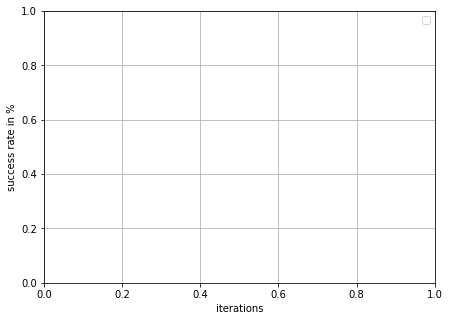

In [116]:
# here you can plot several training curves alongside each other 
# uncomment, delete, edit, copy-paste lines correspondingly
# edit the NAME of the results to be plotted AND edit the LABEL, such that the legend is correct
plt.figure(figsize = (7,5))
#plt.plot(success_rates['success_rates_train6000_test1000_nodes30_iters1000_lr0p03'], label = 'success_rates_train6000_test1000_nodes30_iters1000_lr0.03')
#plt.plot(success_rates['success_rates_train6000_test1000_nodes100_iters1000_lr0p03'], label = 'success_rates_train6000_test1000_nodes100_iters1000_lr0.03')
#plt.plot(success_rates['success_rates_train6000_test1000_nodes300_iters1000_lr0p03'], label = 'success_rates_train6000_test1000_nodes300_iters1000_lr0.03')
#plt.plot(success_rates['success_rates_train6000_test1000_nodes784_iters1000_lr0p03'], label = 'success_rates_train6000_test1000_nodes784_iters1000_lr0.03')
#plt.plot(success_rates['success_rates_train6000_test1000_nodes1000_iters1000_lr0p03'], label = 'success_rates_train6000_test1000_nodes1000_iters1000_lr0.03')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('success rate in %')
plt.grid()
# plt.ylim([80,95]) # uncomment line to restrict the y-range for more detailed view on the late training

In [114]:
# Exercises

# explore the hyperparameters
# - number of nodes
# - learning rate
# - size of traing data set
#
# keep size of test data set constant, e.g. 1000
# 
# a strong increase in number of iterations beyond 1000 is  
# recommended only AFTER exploring other prameters to some extent
